[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/quick-tour/simple-classifier.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/docs/quick-tour/simple-classifier.ipynb)

# Building a Simple Classifier with Pinecone

It is easy to build vector-based ML applications using Pinecone's simple workflow:

1. Create a Pinecone [Index](https://docs.pinecone.io/guides/indexes/understanding-indexes). Once it is created, you will have a production-ready vector database service. (Yes, it's that simple!)

1. Connect to the index. You can then start inserting vectors and getting query results.


In this example, we show you how you can build a simple nearest neighbor classifier. We will sample data from two multivariate normal distributions with different means and equal variance. We will then classify which multivariate normal distribution an unknown vector belongs to by the majority vote of the nearest neighbors’ class labels.

## Prerequisites

Install dependencies.

In [1]:
!pip install -qU \
    matplotlib==3.10.1 \
    pandas==2.2.3 \
    pinecone==6.0.2 \
    seaborn==0.13.2

## Generate data from multivariate normal distributions

In [2]:
import numpy as np

random_state = 321
np.random.seed(random_state)

sample_size = 50000
dim = 10
A_mean = 0.0
B_mean = 2.0

# Create multivariate normal samples
A_vectors = A_mean + np.random.randn(sample_size, dim)
B_vectors = B_mean + np.random.randn(sample_size, dim)

# Query data generated from A distribution
query_size = 20
A_queries = A_mean + np.random.randn(query_size, dim)

Compare the first 2 dimensions of the multivariate normals in a scatterplot.

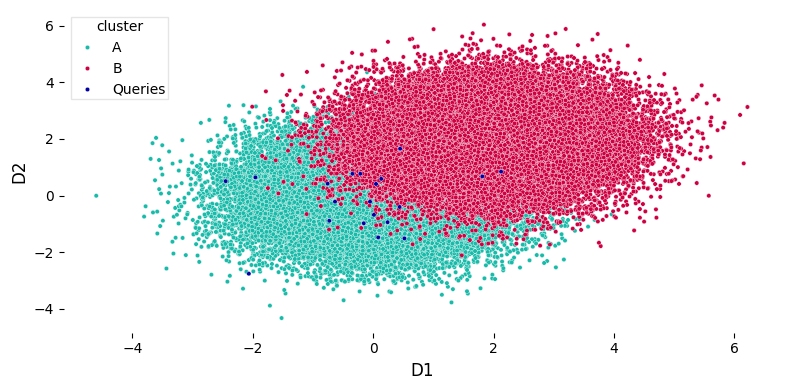

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Let's use our own colors to make things pretty.
pink = (206 / 255, 0 / 255, 65 / 255)
blue = (0 / 255, 0 / 255, 163 / 255)
green = (24 / 255, 187 / 255, 169 / 255)

plot_df = pd.concat(
    [
        pd.DataFrame(dict(D1=A_vectors[:, 0], D2=A_vectors[:, 1], cluster="A")),
        pd.DataFrame(dict(D1=B_vectors[:, 0], D2=B_vectors[:, 1], cluster="B")),
        pd.DataFrame(dict(D1=A_queries[:, 0], D2=A_queries[:, 1], cluster="Queries")),
    ]
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.tick_params(labelsize=10)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
sns.scatterplot(
    data=plot_df,
    x="D1",
    y="D2",
    hue="cluster",
    palette=[green, pink, blue],
    s=10,
    ax=ax,
)
ax.legend(
    title="cluster", loc="upper left", borderpad=0.2, fancybox=False, framealpha=0.5
)
plt.tight_layout()
plt.box(on=None)
plt.show()

# Build a classifier using Pinecone

## Creating an Index

Now the data is ready, we can set up our index to store it.

We begin by initializing our Pinecone client. To do this we need a [free API key](https://app.pinecone.io).

In [4]:
import os
from pinecone import Pinecone

# Get API key at app.pinecone.io
api_key = os.environ.get("PINECONE_API_KEY") or "PINECONE_API_KEY"

# Instantiate the client index
pc = Pinecone(api_key=api_key)

We will using the Euclidean distance as the measure of similarity in this example. We also support `dotproduct` and `cosine` similarity metrics. Refer to the [documentation](https://docs.pinecone.io/guides/indexes/understanding-indexes#similarity-metrics) for all of the supported metrics.

In [5]:
index_name = "simple-knn-classifier"

In [6]:
# Delete the demo index if it already exists
if pc.has_index(name=index_name):
    pc.delete_index(name=index_name)

In [7]:
from pinecone import ServerlessSpec, Metric, CloudProvider, AwsRegion

# Create an index
config = pc.create_index(
    name=index_name,
    dimension=dim,
    metric=Metric.EUCLIDEAN,
    spec=ServerlessSpec(cloud=CloudProvider.AWS, region=AwsRegion.US_EAST_1),
)
config

{
    "name": "simple-knn-classifier",
    "metric": "euclidean",
    "host": "simple-knn-classifier-dojoi3u.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 10,
    "deletion_protection": "disabled",
    "tags": null
}

## Working with the Index

Data operations such as `upsert` and `query` are sent directly to the index host instead of `api.pinecone.io`, so we use a different client object object for these operations. By using the `.Index()` helper method to construct this client object, it will automatically inherit your API Key and any other configurations from the parent `Pinecone` instance.

In [8]:
# Instantiate the index client
index = pc.Index(host=config.host)

In [9]:
# Create a Pandas DataFrame for the data.
items_df = pd.DataFrame()
items_df["id"] = [f"A-{ii}" for ii in range(len(A_vectors))] + [
    f"B-{ii}" for ii in range(len(B_vectors))
]
items_df["vector"] = [*A_vectors.tolist(), *B_vectors.tolist()]
items_df.sample(5)

,id,vector
27490,A-27490,"[-0.0738189388910569, 1.2172645455403326, 0.43..."
81849,B-31849,"[4.200122577274714, 2.2921594288727363, 2.3567..."
98553,B-48553,"[0.2684113917308826, 4.677519902925265, 1.7735..."
96211,B-46211,"[1.2046852878941696, 2.8184499827395535, 0.152..."
72365,B-22365,"[2.5511272846529094, 2.9778061355909404, 0.148..."


In [10]:
# Upload the sample data formatted as (id, vector) tuples.
index.upsert(
    vectors=[(row.id, row.vector) for _, row in items_df.iterrows()],
    batch_size=100,
)

Upserted vectors:   0%|          | 0/100000 [00:00<?, ?it/s]

{'upserted_count': 100000}

In [11]:
# index info
index.describe_index_stats()

{'dimension': 10,
 'index_fullness': 0.0,
 'metric': 'euclidean',
 'namespaces': {'': {'vector_count': 100000}},
 'total_vector_count': 100000,
 'vector_type': 'dense'}

In [12]:
from collections import Counter

# We expect most of a query's nearest neighbors are from the A distribution
for query_vec in A_queries.tolist()[:2]:
    result = index.query(vector=query_vec, top_k=10)
    cc = Counter(match.id.split("-")[0] for match in result.matches)
    print(f"Count nearest neighbors' class labels: A={cc['A']}, B={cc['B']}")

Count nearest neighbors' class labels: A=10, B=0
Count nearest neighbors' class labels: A=10, B=0


### Delete the index

After we're done, we delete the index to save resources.

In [13]:
# Delete the index
pc.delete_index(name=index_name)